# MIS 583 Assignment 2: Multi-class Classification

Before we start, please put your name and ID in following format  
: LASTNAME Firstname, ?000000000   //   e.g.) 李晨愷, M114020035

**Your Answer:**   
Hi I'm 鄔仁迪, B104020009

## Image Classification

Image classification is a core and fundamental task in computer vision.

In this assignment, you will implement a multi-class image classifier to recognize fashion items images.

You will design and train a multi-layer perceptron (MLP) **not using the convolution layers** from scratch that predicts the class label of a clothes image. This will help you gain experience with network design and get more familiar with PyTorch.

## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish datasets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/44dc917fe20b44a3b3c20954c5084975) to join the competition.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

We use `python==3.10.12`, `torch==2.0.1+cu118` and `torchvision==0.15.2+cu118`. This is the default version in Google Colab.

In [1]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]
torch 2.0.1+cu118
torchvision 0.15.2+cu118


## Error handling

**RuntimeError: CUDA out of memory...**
> 發生原因可能為讀取的 batch 過大或是記憶體未釋放乾淨。若縮小 batch size 後仍出現錯誤請按照以下步驟重新載入 colab。
> The reason of this error is over-sized batch_size or unreleased memory. If changing the batch_size smaller still cause this error. Please reload colab follow below instructions.

1. Click 「Runtime」
2. Click 「Factor reset runtime」
3. Click 「Reconnect」
4. Reload all chunk

# Fashion-MNIST dataset

One of the widely used dataset for image classification is the MNIST dataset.
While it had a good run as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over 95%, making it unsuitable for distinguishing between stronger models and weaker ones.
Today, MNIST serves as more of sanity checks than as a benchmark.
To up the ante just a bit, we will use the qualitatively similar, but comparatively complex Fashion-MNIST dataset, which was released in 2017.

The Fashion-MNIST consists of a training set of 60,000 examples and a test set of 10,000 examples.
It has **10 classes: 't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'.**
The images are of size 1x28x28, i.e., 1-channel grayscale images of 28x28 pixels in size.
This pixel-value is an integer between 0 and 255.

Here shows some Fashion-MNIST images.

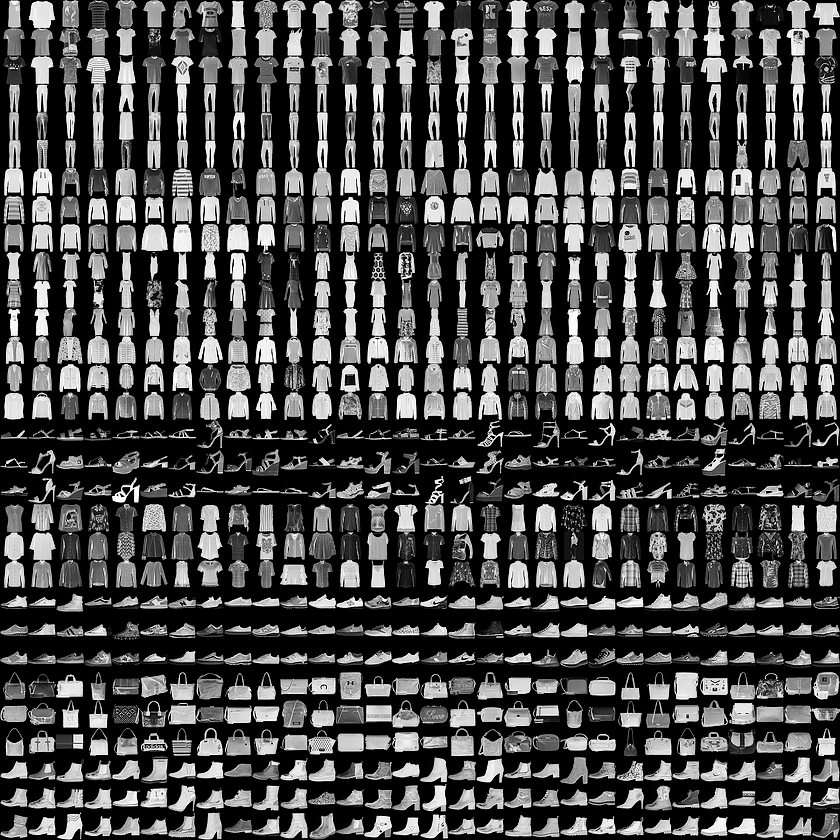

## How to Get Data

請先到共用雲端硬碟將檔案 `A2_data_FashionMNIST_2023.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/1n98LPzK1vp3rawq1riaf58U8VmspJPTN/view?usp=drive_link)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

## Unzip Data

解壓縮 `A2_data_flower_2022.zip` 後可以發現裡面有3個csv檔。

+ `fashion-mnist_train.csv` : 裡面含有10個類別的label和28 * 28 pixel用來訓練
+ `fashion-mnist_val.csv` : 裡面含有10個類別的label和28 * 28 pixel用來訓練
+ `fashion-mnist_test.csv` : 裡面含有10個類別的label和28 * 28 pixel用來測試

其中`train`的圖片 48000 張，`val` 的圖片 12000 張, `test` 的圖片 10000 張。

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [2]:
# !unzip -qq ./drive/MyDrive/A2_data_FashionMNIST_2023.zip

# **Step 1: Loading the dataset**

## Import the necessary modules

`torch` is the main module that holds all the things we need for Tensor computation. We’ll make use of the more powerful and convenient `torch.nn`, `torch.optim` and `torchvision` classes to quickly build our neural network.

`torchvision` contains a lot of popular datasets, model architectures, and common image transformations for computer vision.

Run the cell below to load the required PyTorch packages.

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [4]:
train_csv = pd.read_csv("fashion-mnist_train.csv")
val_csv = pd.read_csv("fashion-mnist_val.csv")
test_csv = pd.read_csv("fashion-mnist_test.csv")

In [5]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""

    def __init__(self, data, mode='train', transform = None):
        """Method to initilaize variables."""
        self.mode = mode
        self.fashion_MNIST = list(data.values)
        self.transform = transform

        label = []
        image = []

        for i in self.fashion_MNIST:
             # first column is of labels.
            image.append(i[1:])
            if mode != 'test':
                label.append(i[0])
                self.labels = np.asarray(label)

        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('uint8')

    def __getitem__(self, index):

        image = self.images[index]

        if self.transform is not None:
            image = self.transform(image)

        if self.mode == 'test':
            return image
        label = self.labels[index]
        return image, label

    def __len__(self):
        return len(self.images)

In [6]:
transform = transforms.ToTensor()

In [7]:
trainset = FashionDataset(train_csv, mode='train',transform=transform)
valset = FashionDataset(val_csv, mode='val', transform=transform)
testset = FashionDataset(test_csv, mode='test', transform=transform)

In [8]:
len(trainset), len(valset) ,len(testset)

(48000, 12000, 10000)

In [9]:
trainset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

## `DataLoader`

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ `shuffle` : set to `True` to have the data reshuffled at every epoch
+ `batch_size` : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [10]:
batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

# **Step 2: Build a MLP (Multiple Layer Perceptron) using PyTorch**

Increasing the number of layers will give the model with a greater capacity.  

**You should make a network with depths >=2 and not using the convolution layers!!!**

You should be able to achieve a better accuracy by trying
- Different activation functions
- More layers
- Add some Normalization or Tricks (dropout, BatchNorm)  



In [11]:
import torch.nn as nn
import torch.nn.functional as F

class TorchMLP(nn.Module):
    def __init__(self):
        '''
        Initiate weights and bias of our model.

        Arguments:
        feature_dim -- int, How many features your data have.
        '''
        super().__init__()
        # init the weight AND bias by nn.Linear
        ########################################################################
        # TODO: use nn.xxx method to MLP layer                                 #
        #   output of previous layer should fit input of the next layer        #
        ########################################################################
        self.linear1 = nn.Linear(in_features=28 * 28, out_features=1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.linear2 = nn.Linear(in_features=1024, out_features=1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.linear3 = nn.Linear(in_features=1024, out_features=512)
        self.bn3 = nn.BatchNorm1d(512)
        self.linear4 = nn.Linear(in_features=512, out_features=32)
        self.bn4 = nn.BatchNorm1d(32)
        self.linear5 = nn.Linear(in_features=32, out_features=10)

        self.dropout = nn.Dropout()

        for layer in [self.linear1, self.linear2, self.linear3, self.linear4, self.linear5]:
            nn.init.xavier_uniform_(layer.weight)
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)
        ########################################################################
        # TODO: forward your model and get output                              #
        #   Don't forget activation function. But, you can't use previous      #
        #   defined sigmoid, try to search in PyTorch docs                     #
        ########################################################################
        out = F.relu(self.bn1(self.linear1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn2(self.linear2(out)))
        out = self.dropout(out)
        out = F.relu(self.bn3(self.linear3(out)))
        out = self.dropout(out)
        out = F.relu(self.bn4(self.linear4(out)))
        out = self.dropout(out)
        out = self.linear5(out)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

In [12]:
device = torch.device('cuda')

In [13]:
# TODO: uncomment the model you want to use
model = TorchMLP()

model = model.to(device)
print(model)

TorchMLP(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=512, out_features=32, bias=True)
  (bn4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# **Step 3: Define loss and optimizer**

Once the network model is defined, we procced to define the loss function and the optimizer.
We'll use `torch.optim` for this, because it offers all the commonly-used loss functions and optimizers like SGD, ADAM, and so on.

Let’s use a Classification Cross-Entropy loss and SGD.

In [14]:
import torch.optim as optim

########################################################################
# TODO: Define loss and optmizer functions                             #
# please use Cross Entropy and SGD optimizer                    #
# hint: torch.nn and torch.optim                                       #
########################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.00001)
########################################################################
#                           End of your code                           #
########################################################################
criterion = criterion.to(device)

# **Step 4: Train the model**

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

## Train function

Let's define a train function first. It is to iterate the training examples for one epoch and update the model at each iteration using the optmizer specified above.

This train function also computes the mean loss averaged over all iterations and the classification accuray.

In [15]:
def train(trainloader, model, criterion, optimizer):
  '''
  Argement:
  input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
  model -- nn.Module, model contain forward to predict output
  criterion -- loss function, used to evaluate goodness of model
  optimizer -- optmizer function, method for weight updating
  '''
  model.train()
  loss_list = []
  total = 0
  correct = 0
  for i, (images, labels) in enumerate(trainloader):
    images = images.reshape(-1, 28*28)
    images, labels = images.cuda(), labels.cuda()

    ########################################################################
    # Forward, backward and optimize                                       #
    # 1. zero the parameter gradients                                      #
    # 2. process input through the network                                 #
    # 3. compute the loss                                                  #
    # 4. propagate gradients back into the network’s parameters            #
    # 5. Update the weights of the network                                 #
    ########################################################################
    # print("1. zero the parameter gradients ")
    optimizer.zero_grad()
    # print("2. process input through the network ")
    outputs = model(images)
    # print("3. compute the loss ")
    loss = criterion(outputs, labels)
    # print("4. propagate gradients back into the network’s parameters ")
    loss.backward()
    # print("5. Update the weights of the network ")
    optimizer.step()
    ########################################################################
    #                           End of your code                           #
    ########################################################################
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0) #out.shape[0]
    correct += (predicted == labels).sum().item()
    loss_list.append(loss.item())

  # Compute this epoch accuracy and loss
  acc = correct / total
  loss = sum(loss_list) / len(loss_list)
  return acc, loss

Next, we write the val function that works similarly as the training function but without the optmizer and weigght-updating parts.

In [16]:
def val(valloader, model, criterion):
  model.eval()

  loss_list = []
  total = 0
  correct = 0
  with torch.no_grad():
    for images, labels in valloader:
      images = images.reshape(-1, 28*28)
      images, labels = images.cuda(), labels.cuda()

      ####################################################################
      # Get the predicted result and loss                                #
      # 1. process input through the network                             #
      # 2. compute the loss                                              #
      ####################################################################
      outputs = model.forward(images)
      loss = criterion(outputs, labels)
      ####################################################################
      #                           End of your code                       #
      ####################################################################
      _, predicted = torch.max(outputs, 1)
      total += outputs.size(0)
      correct += (predicted == labels).sum().item()
      loss_list.append(loss.item())

    acc = correct / total
    loss = sum(loss_list) / len(loss_list)
    return acc, loss

Finally, call the train and val functions in a loop. We also record the training/val losses and accuracies during the course of training.

In [310]:
################################################################################
# You can adjust those hyper parameters to loop for max_epochs times           #
################################################################################
max_epochs = 50000
max_val_acc = 0.9055
log_interval = 1 # print acc and loss in per log_interval time
################################################################################
#                               End of your code                               #
################################################################################
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(1, max_epochs+1):
  # train the model
  train_acc, train_loss = train(trainloader, model, criterion, optimizer)
  # we should use a validation set to evaluate the model generability and for
  # determining the hyperparameters.
  # for simplicity, we use the test set here to understand how the model
  # performs on unseen data
  val_acc, val_loss = val(valloader, model, criterion)

  # accumulate accuracy and loss
  train_acc_list.append(train_acc)
  train_loss_list.append(train_loss)
  val_acc_list.append(val_acc)
  val_loss_list.append(val_loss)

  # print the accuracy and loss
  if epoch % log_interval == 0:
    print('=' * 20, 'Epoch', epoch, '=' * 20)
    print('Train Acc: {:.6f} Train Loss: {:.6f}'.format(train_acc, train_loss))
    print(' Val Acc: {:.6f}  Val Loss: {:.6f}'.format(val_acc, val_loss))
    if val_acc > max_val_acc:
        max_val_acc = val_acc
        torch.save(model.state_dict(), f'result_{max_val_acc}.pt')

==================== Epoch 1 ====================
Train Acc: 0.946979 Train Loss: 0.164304
 Val Acc: 0.904833  Val Loss: 0.347428
==================== Epoch 2 ====================
Train Acc: 0.945021 Train Loss: 0.169058
 Val Acc: 0.904583  Val Loss: 0.341702
==================== Epoch 3 ====================
Train Acc: 0.946250 Train Loss: 0.167117
 Val Acc: 0.904833  Val Loss: 0.351333
==================== Epoch 4 ====================
Train Acc: 0.945917 Train Loss: 0.165860
 Val Acc: 0.903917  Val Loss: 0.348038
==================== Epoch 5 ====================
Train Acc: 0.945708 Train Loss: 0.167751
 Val Acc: 0.904667  Val Loss: 0.348892
==================== Epoch 6 ====================
Train Acc: 0.945271 Train Loss: 0.170568
 Val Acc: 0.906000  Val Loss: 0.343498
==================== Epoch 7 ====================
Train Acc: 0.946479 Train Loss: 0.167242
 Val Acc: 0.905417  Val Loss: 0.347501
==================== Epoch 8 ====================
Train Acc: 0.946375 Train Loss: 0.165543

KeyboardInterrupt: 

In [306]:
torch.save(model.state_dict(), 'result.pt')

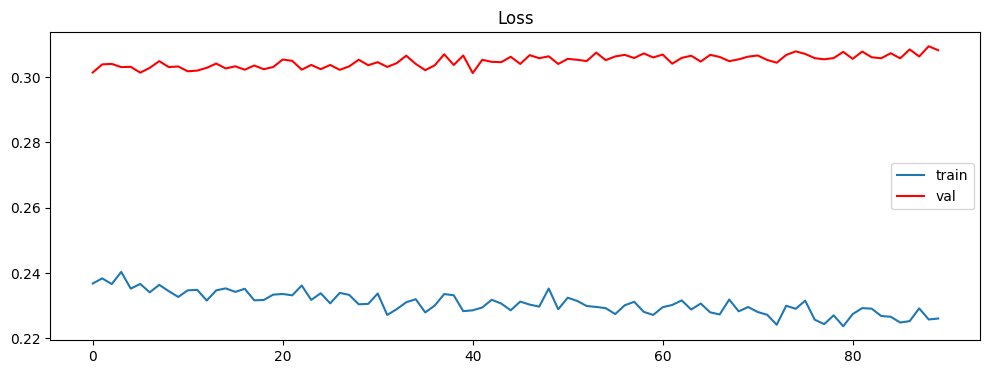

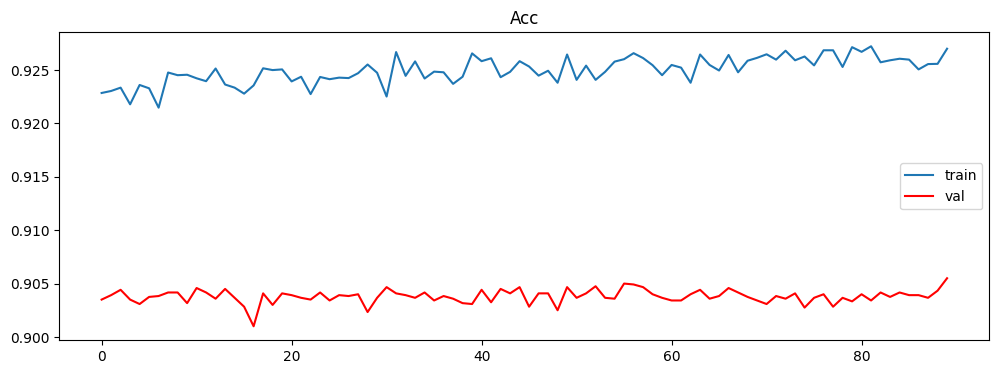

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

### Predict Result

Predict the labels based on testing set. Upload to [Kaggle](https://www.kaggle.com/competitions/mis583-fashionmnist-classification/).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 70% dataset and publish this result to leaderboard.

---

預測`test`並將結果上傳至Kaggle。[**連結**](https://www.kaggle.com/competitions/mis583-fashionmnist-classification/)

執行完畢此區的程式碼後，會將`test`預測完的結果存下來。

上傳流程
1. 點選左側選單最下方的資料夾圖示
2. 右鍵「result.csv」
3. 點選「Download」
4. 至連結網頁點選「Submit Predictions」
5. 將剛剛下載的檔案上傳
6. 系統會計算並公布其中70%資料的正確率

In [17]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [24]:
# if you wanna load previous best model
ckpt = torch.load('result_0.9055.pt')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [25]:
import csv
idx = 0
output_csv = predict(testloader, model)
with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['id', 'label'])
    writer.writeheader()
    for result in output_csv:
        id = idx
        writer.writerow({'id':id, 'label':result})
        idx += 1